## Primary Notebook

Notebook contains the following, in order: 
- Steady State Prelims:
    - asdf
- Steady State final 
- Steady State final with capacitor
- Comparison of the 2
- Transient Prelims: 
    - asdf
- Transient final
- Transient final with capacitor


In [262]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as spi

# set random seed
np.random.seed(41)

## Section III.A: A Simpler Starter Problem

Basic example with resisitive loads and DC source to show admittance matrices and circuit basics

Circuit in question (Fig. 4):

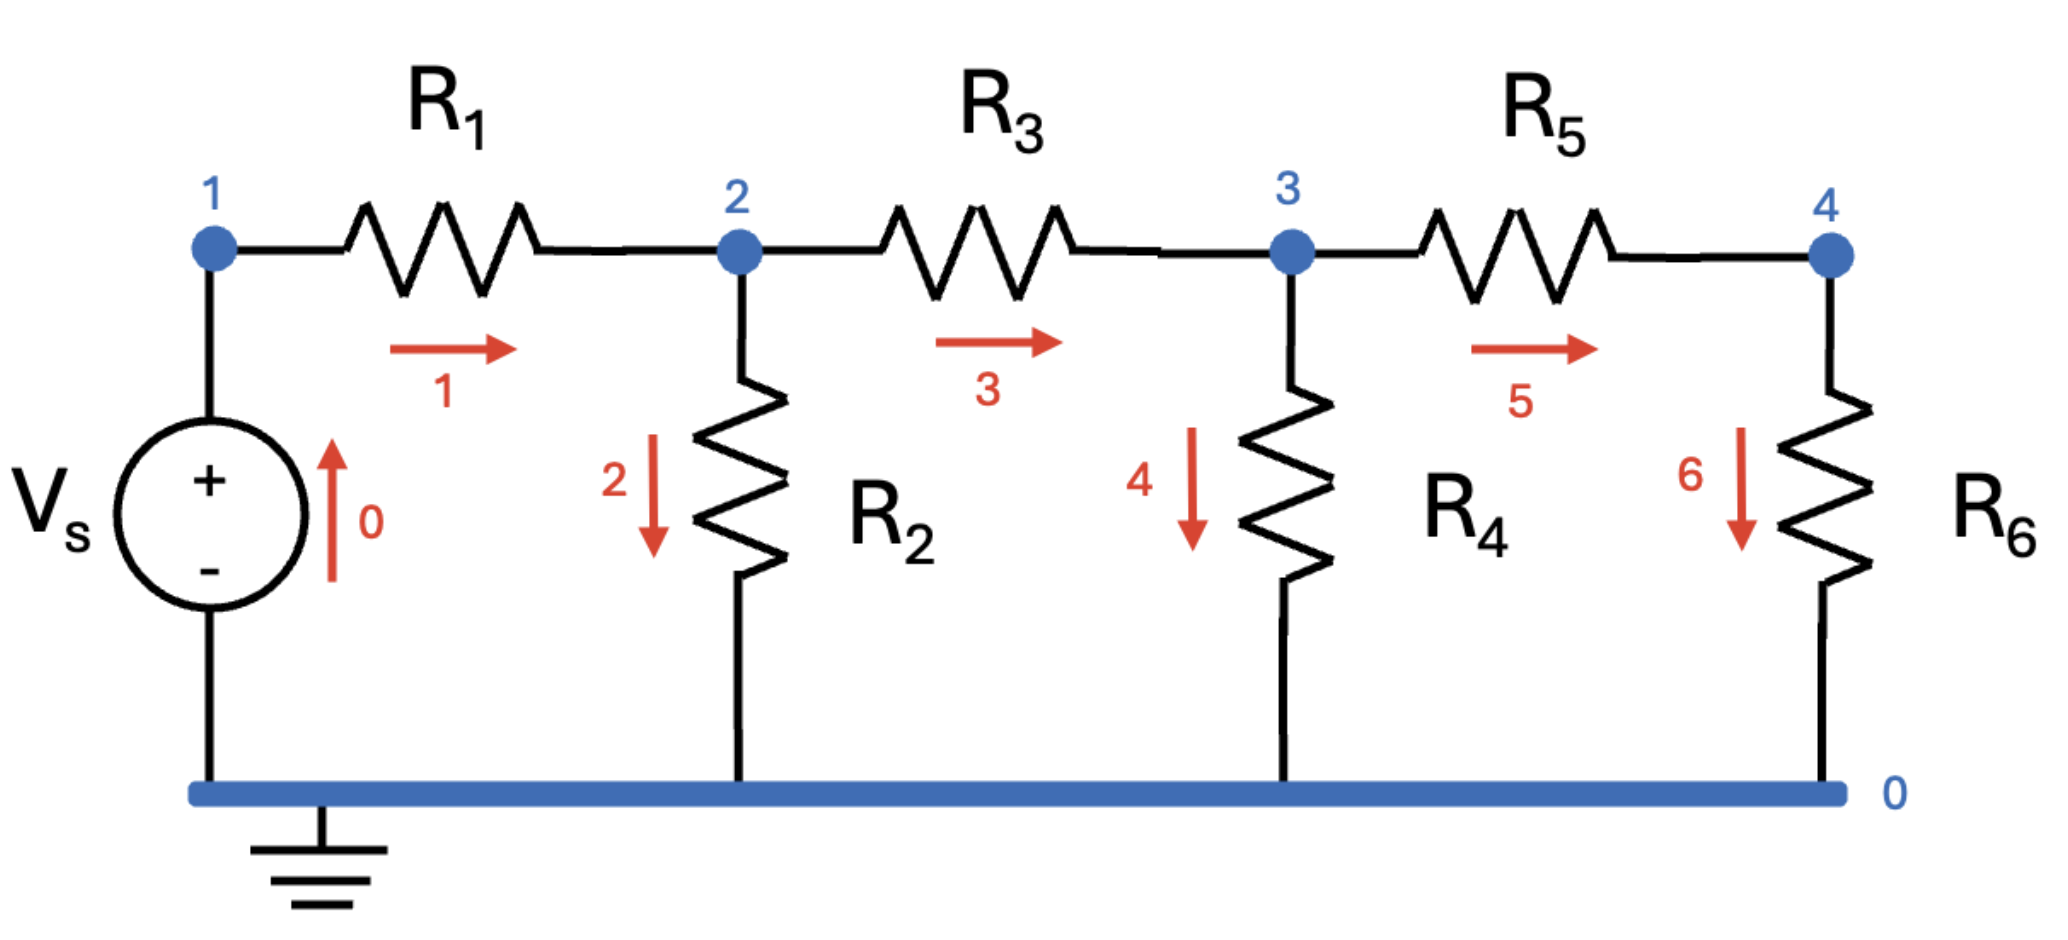

In [263]:
r = np.array([0.1, 1.5, 0.3, 1.2, 0.2, 1.7])  # Resistances in Ohms
Vs = 24
g = 1 / r  # Conductances 
Is = g[0] * Vs
Ivec = np.array([Is, 0, 0])
Gm = np.array([[g[0] + g[1] + g[2], -g[2], 0],
              [-g[2], g[2] + g[3] + g[4], -g[4]],
              [0, -g[5], g[4] + g[5]]])  # Conductance matrix
Vall = np.linalg.inv(Gm) @ Ivec  # Solve for voltages
print(f"Voltages in circuit: V2={Vall[0]:.2f} V, V3={Vall[1]:.2f} V, V4={Vall[2]:.2f} V")
Pall = np.array([g[1], g[3], g[5]]) * Vall**2  # Power in each branch
print(f"Power in circuit: P2={Pall[0]:.2f} W, P4={Pall[1]:.2f} W, P6={Pall[2]:.2f} W")

Voltages in circuit: V2=18.88 V, V3=7.28 V, V4=0.77 V
Power in circuit: P2=237.55 W, P4=44.19 W, P6=0.35 W


## Section III.B: Extension to AC Complex Loads

Increasing from 3 loads to 5 loads, including an AC source, and using complex impedances instead of just resistance

Circuit in question (Fig. 5):

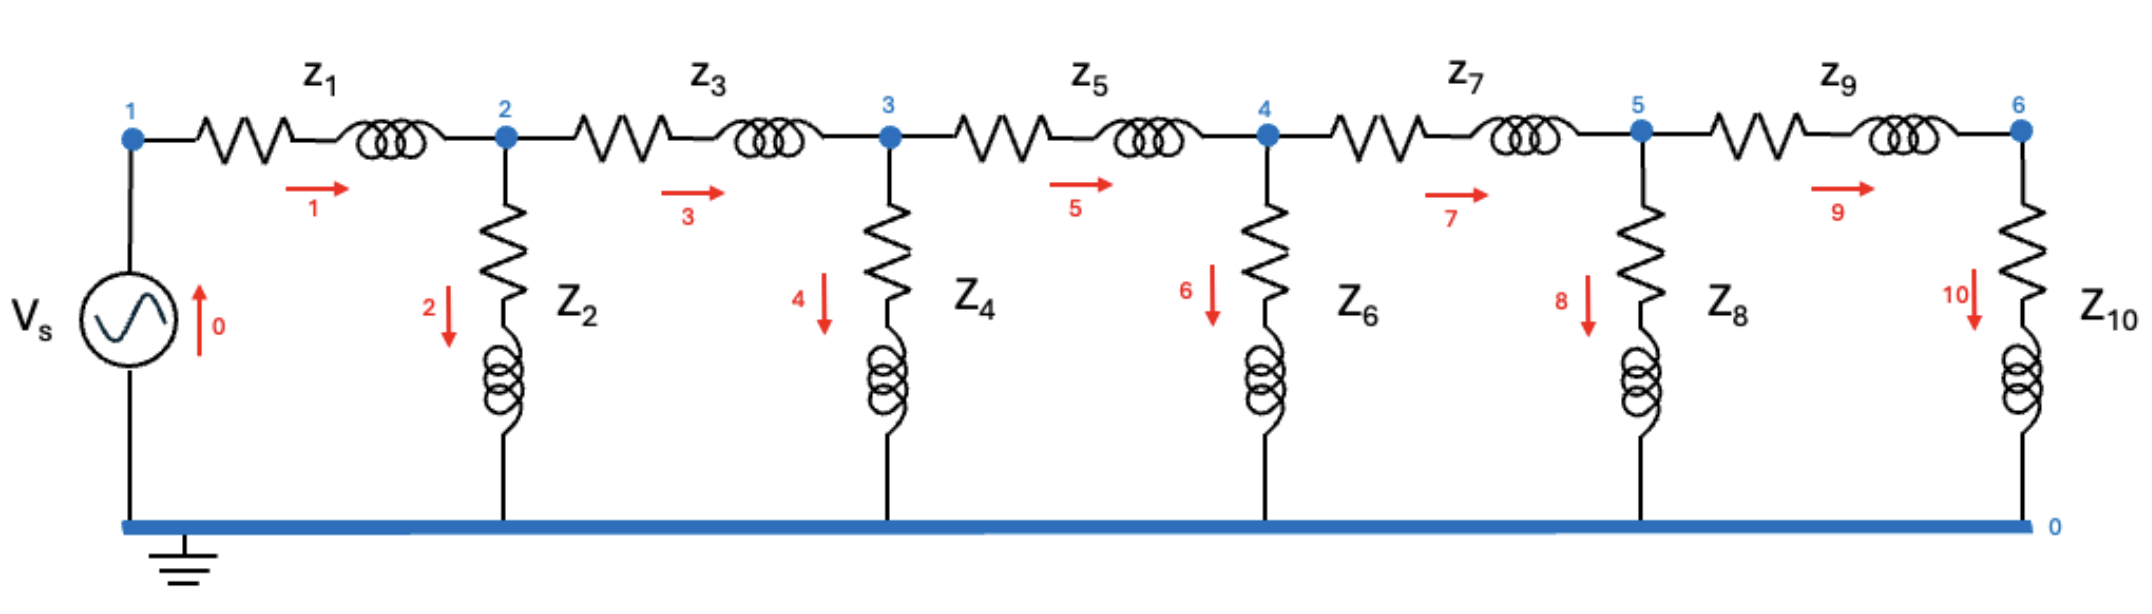

In [264]:
## Functions needed: 

# compute voltages using admittance matrix and source voltage
def compute_voltages(zline, zload, Vs):
    z = np.column_stack((zline, zload)).ravel()  # Combine line and load impedances
    y = 1 / z  # Admittance
    Ym = np.array([  [y[0]+y[1]+y[2], -y[2],           0,              0,              0],
                    [-y[2],           y[2]+y[3]+y[4], -y[4],          0,              0],
                    [0,               -y[4],          y[4]+y[5]+y[6], -y[6],          0],
                    [0,               0,              -y[6],          y[6]+y[7]+y[8], -y[8]],
                    [0,               0,              0,              -y[8],          y[8]+y[9]]])  # Admittance matrix
    i = np.array([Vs * y[0], 0, 0, 0, 0])  # Current vector
    Vall = np.linalg.inv(Ym) @ i  # Solve for voltages
    Vmag = np.abs(Vall)  # Magnitude of voltages
    Vphase = np.degrees(np.angle(Vall))  # Phase of voltages
    return Vall, Vmag, Vphase

# print table for latex
def print_latex_table(zload, zline, Vmag, Vphase, S):
    zldr = 1        # zload round number
    zlnr = 2        # zline round number
    Pr = 3          # power rounding
    Qr = 3          # Q rounding
    S = S / 1e3         # convert s to kW/kVAr

    print("\\begin{table}[ht]")
    print("\\centering")
    print("\\caption{The units are $\\Omega$, $V$, degrees, $\\text{kW}$ and $\\text{kVAr}$.}")
    print("\\label{tab:}")
    print("\\begin{tabular}{|c|c|c|c|c|}")
    print("\\hline")
    print("$Z_2$ & $Z_4$ & $Z_6$ & $Z_8$ & $Z_{10}$ \\\\")
    print(f"{np.round(zload[0],zldr)} & {np.round(zload[1],zldr)} & {np.round(zload[2],zldr)} & {np.round(zload[3],zldr)} & {np.round(zload[4],zldr)} \\\\")
    print("\\hline")
    print("$Z_1$ & $Z_3$ & $Z_5$ & $Z_7$ & $Z_9$ \\\\")
    print(f"{np.round(zline[0],zlnr)} & {np.round(zline[1],zlnr)} & {np.round(zline[2],zlnr)} & {np.round(zline[3],zlnr)} & {np.round(zline[4],zlnr)} \\\\")
    print("\\hline")
    print("$|V_2|$ & $|V_3|$ & $|V_4|$ & $|V_5|$ & $|V_6|$ \\\\")
    print(f"{np.round(Vmag[0], 2)} & {np.round(Vmag[1], 2)} & {np.round(Vmag[2], 2)} & {np.round(Vmag[3], 2)} & {np.round(Vmag[4], 2)} \\\\")
    print("\\hline")
    print("$\\angle V_2$ & $\\angle V_3$ & $\\angle V_4$ & $\\angle V_5$ & $\\angle V_6$ \\\\")
    print(f"{np.round(Vphase[0], 2)} & {np.round(Vphase[1], 2)} & {np.round(Vphase[2], 2)} & {np.round(Vphase[3], 2)} & {np.round(Vphase[4], 2)} \\\\")
    print("\\hline")
    print("$P_2$ & $P_3$ & $P_4$ & $P_5$ & $P_6$ \\\\")
    print(f"{np.round(S[0].real, Pr)} & {np.round(S[1].real, Pr)} & {np.round(S[2].real, Pr)} & {np.round(S[3].real, Pr)} & {np.round(S[4].real, Pr)} \\\\")
    print("\\hline")
    print("$Q_2$ & $Q_3$ & $Q_4$ & $Q_5$ & $Q_6$ \\\\")
    print(f"{np.round(S[0].imag, Qr)} & {np.round(S[1].imag, Qr)} & {np.round(S[2].imag, Qr)} & {np.round(S[3].imag, Qr)} & {np.round(S[4].imag, Qr)} \\\\")
    print("\\hline")
    print("\\end{tabular}")
    print("\\end{table}")

# get numerical derivative of an array of time-signals x(t)
def get_deriv(x,t):
    dxdt = np.zeros(x.shape)
    for i in range(x.shape[0]):
        dxdt[i,:] = np.gradient(x[i,:],t)
    return dxdt

In [265]:
showprint = False                # turn on to print latex tables

# Define Initial conditions - SAME for all full-size simulations!! 
## Set up / constants
Vs = 240 + 0*1j  # Source voltage
zline = np.random.uniform(3e-2, 7e-2, size=(5)) + 1j * np.random.uniform(3e-2, 7e-2, size=(5))  # Random complex impedances
# initial loads
zload = np.random.uniform(20, 40, size=(5)) + 1j * np.random.uniform(5, 10, size=(5))        # Random complex loads with reasonable power factor

## Before load change
# compute voltages
Vall, Vmag, Vphase = compute_voltages(zline, zload, Vs)
# Calculate power
Sall = abs(Vall)**2 / zload.conjugate()


## Section III.C: A Step Change in Load

Step change the load at node 4 by cutting the impedance in half. Refer to Fig. 6

In [266]:
## After load change
# initial loads
zload2 = zload * np.array([1, 1, 0.5, 1, 1])        # double load by halfing impedance
V2all, Vmag2, Vphase2 = compute_voltages(zline, zload2, Vs)
S2all = abs(V2all)**2 / zload2.conjugate()

## Section III.D: Adding a Capacitor

To correct power factor for the load at Node 4, a capacitor bank is added 

Circuit in question (Fig. 8):

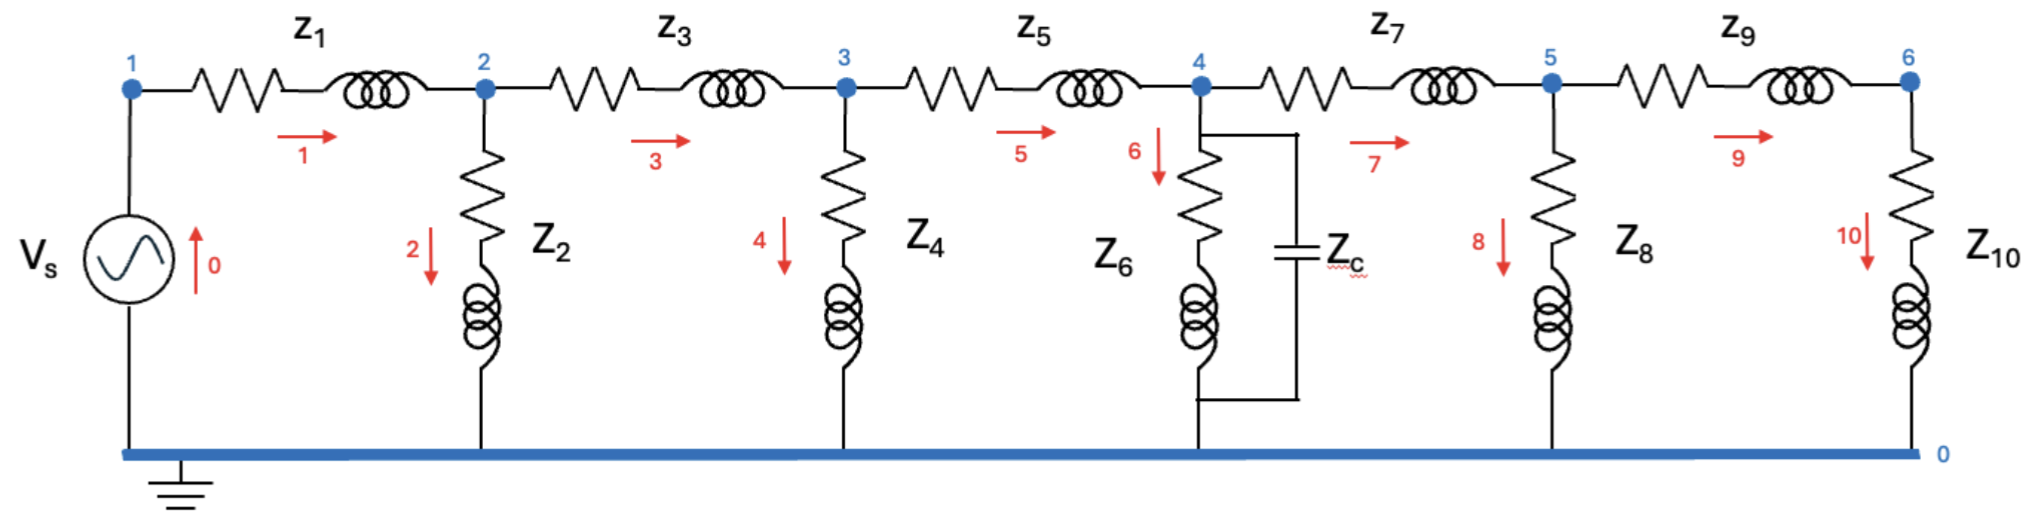

In [267]:
## Adding a capacitor to the network at Node 4
# initial loads
Xc = (Vmag[2])**2 / np.imag(Sall[2]) / 25              # compute Xc value
Cap = 1/2/np.pi/60/Xc
zc = 0 - 1j*Xc                                  # define capacitor impedance
z_eq3 = (zload[2] * zc) / (zload[2] + zc)       # find equivalent impedance with capacitor in parallel
zload3 = zload.copy()                           # initialize new load same as first load
zload3[2] = z_eq3                               # replace with capacitor load
# compute voltages
V3all, Vmag3, Vphase3 = compute_voltages(zline, zload3, Vs)
# Calculate power
S3all = abs(V3all)**2 / zload3.conjugate()
# print capacitance to be used later on
print('The reactance due to the capacitor is (ohms):')
print(Xc)
print('The capacitance corresponding to this reactance at 60Hz is (Farads):')
print(Cap)


## After load change
# initial loads
zld2 = zload2[2]                                # pull the doubled load impedance out
z_eq4 = (zld2 * zc) / (zld2 + zc)               # find equivalent impedance with capacitor in parallel
zload4 = zload.copy()                           # initialize new load same as first load
zload4[2] = z_eq4                               # replace with capacitor load - complete load vector for new set up
# compute voltages
V4all, Vmag4, Vphase4 = compute_voltages(zline, zload4, Vs)
# Calculate power
S4all = abs(V4all)**2 / zload4.conjugate()

The reactance due to the capacitor is (ohms):
3.6883016201470387
The capacitance corresponding to this reactance at 60Hz is (Farads):
0.000719188032338628


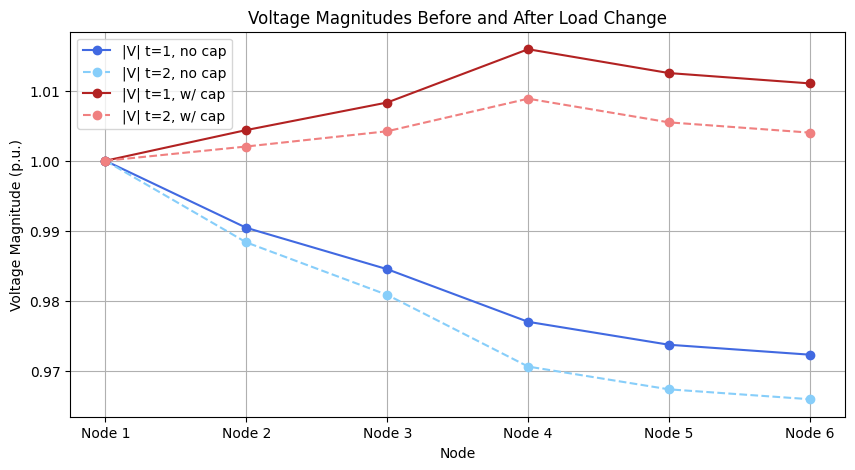

In [268]:
## Plot the voltage profiles - Making of Fig. 7, 10, 11
Vmagp = np.insert(Vmag, 0, 240)     # Insert the source voltage at the beginning
Vmagp2 = np.insert(Vmag2, 0, 240)   # Insert the source voltage at the beginning
Vmagp3 = np.insert(Vmag3, 0, 240)   # Insert the source voltage at the beginning
Vmagp4 = np.insert(Vmag4, 0, 240)   # Insert the source voltage at the beginning
plt.figure(figsize=(10, 5))
plt.plot(Vmagp/240, marker='o', label='|V| t=1, no cap', color='royalblue')
plt.plot(Vmagp2/240,'--', marker='o', label='|V| t=2, no cap', color='lightskyblue')
plt.plot(Vmagp3/240, marker='o', label='|V| t=1, w/ cap', color='firebrick')                # comment to show pre-load-change
plt.plot(Vmagp4/240,'--', marker='o', label='|V| t=2, w/ cap', color='lightcoral')          # comment to show pre-load-change
plt.xlabel('Node')
plt.ylabel('Voltage Magnitude (p.u.)')
plt.title('Voltage Magnitudes Before and After Load Change')
plt.xticks(ticks=np.arange(6), labels=[f'Node {i+1}' for i in range(6)])
plt.legend()
plt.grid()


# print results in latex table form for the paper
if showprint: 
    print("=1=1=1=1=1=1=1=1=1=1=1=1= TABLE FOR EX2 BEFORE LOADING CHANGE =1=1=1=1=1=1=1=1=1=1=1=1=1=1=1=")
    print_latex_table(zload, zline, Vmag, Vphase, Sall)
    print("=1=1=1=1=1=1=1=1=1=1=1=1= TABLE FOR EX2 AFTER LOADING CHANGE =1=1=1=1=1=1=1=1=1=1=1=1=1=1=1=")
    print_latex_table(zload2, zline, Vmag2, Vphase2, S2all)
    print("=1=1=1=1=1=1=1=1=1=1=1=1= TABLE FOR EX3 BEFORE LOADING CHANGE =1=1=1=1=1=1=1=1=1=1=1=1=1=1=1=")
    print_latex_table(zload3, zline, Vmag3, Vphase3, S3all)
    print("=1=1=1=1=1=1=1=1=1=1=1=1= TABLE FOR EX3 AFTER LOADING CHANGE =1=1=1=1=1=1=1=1=1=1=1=1=1=1=1=")
    print_latex_table(zload4, zline, Vmag4, Vphase4, S4all)
    
plt.show()

## Section IV.A: Back to DC

Analysis of a small circuit in DC with a switch closing to see the transient response. The switch moves from being OPEN to CLOSED

Circuit in question (Fig. 11):

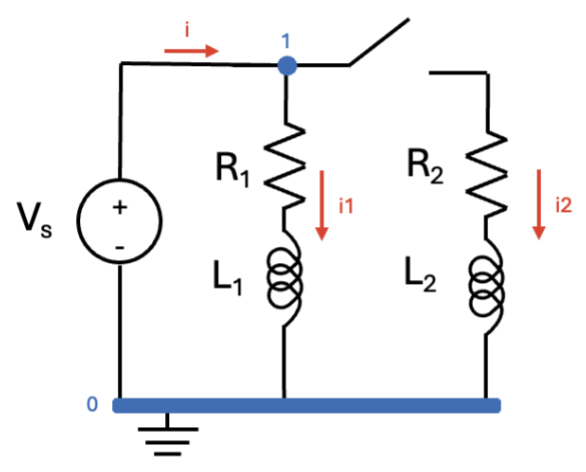

In [269]:
## Constants: 
Rall = np.array([4, 3])            # ohms
Lall = np.array([0.25, 0.5])       # henrys
Vs = 24                         # volts

## Determine initial conditions needed for differential equation
i_0 = Vs / Rall[0]         # Ohm's law - initial current flowing through connected branch
i1_0 = i_0              # initially no current in the other branch so... 
i2_0 = 0                # "    "
# Write differential equation as a function
def dxdt(t, x):
    Am = np.array([
        [   -Rall[0]/Lall[0],    0],
        [   0,             -Rall[1]/Lall[1]]
    ])
    b = np.array([
        Vs / Lall[0],
        Vs / Lall[1]
    ])
    return Am @ x + b

## simulate the response
tspan = (0,2)
x0 = [i1_0, i2_0]
sol = spi.solve_ivp(dxdt, tspan, x0)

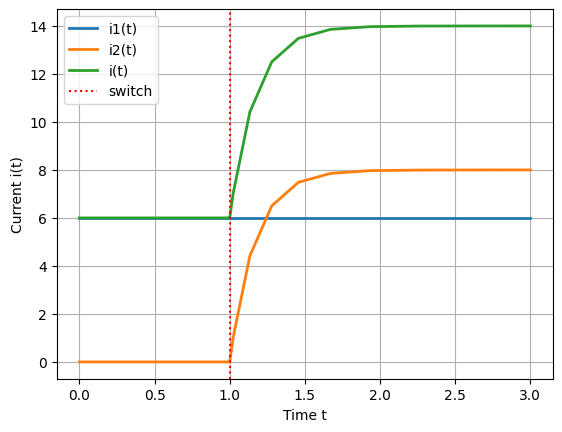

In [270]:
## Making of Fig. 13
# add initial conditions for plotting
t_init = 1      # length of time for initial 
step = 0.1      # step size
t_init_rng = np.arange(0,t_init,step)               # make steps
i1_init = i1_0 * np.ones(t_init_rng.shape)          # make init i1 signal
i2_init = i2_0 * np.ones(t_init_rng.shape)          # i2
i_init = i_0 * np.ones(t_init_rng.shape)            # i
t = np.concatenate((t_init_rng, sol.t+t_init))      # make total time vector
i1_t = np.concatenate((i1_init, sol.y[0]))          # concat
i2_t = np.concatenate((i2_init, sol.y[1]))          # concat
i_t = np.concatenate((i_init, sol.y[0]+sol.y[1]))   # concat

# plot the response
plt.plot(t, i1_t, label='i1(t)',linewidth=2)
plt.plot(t, i2_t, label='i2(t)',linewidth=2)
plt.plot(t, i_t, label='i(t)',linewidth=2)
plt.axvline(x=t_init,label='switch',color='r',linestyle=':')
plt.xlabel('Time t')
plt.ylabel('Current i(t)')
plt.grid(True)
plt.legend()
plt.show()

## Section IV.B: An AC Example

Same circuit as above but now with an AC voltage source, and different values for impedances, pulled from original full-network values

In [271]:
## Constants: 
f = 60                          # hz 
Rall = np.real(zload[0:2])         # ohms
XLall = np.imag(zload[0:2])        # ohms
print(Rall)
print(XLall)
Lall = XLall / 2/ np.pi/ f            # henrys
Zall = zload[0:2]                  # ohms - complex impedance - pulled from full-network load values
# rms values: 
Vs = 240                        # volts  (rms) (phasor)
Is = Vs / Zall[0]                  # phasor, rms
# convert phasors to time-domain functions
def Vs_t(t,Vs,f):
    return Vs * np.sqrt(2) * np.cos(2*np.pi*f*t)
def Is_t(t,Is,f):
    return np.abs(Is)*np.sqrt(2) * np.cos(2*np.pi*f*t + np.angle(Is))

## Find initial currents
Is0 = Is_t(0.02,Is,f)
i1_0 = Is0
i2_0 = 0

## Write the differential equations
def dxdt(t, x):
    Am = np.array([
        [-Rall[0]/Lall[0],  0],
        [0,                 -Rall[1]/Lall[1]]
    ])
    b = np.array([
        Vs_t(t,Vs,f) / Lall[0],    # note Vs is explicit in time now
        Vs_t(t,Vs,f) / Lall[1]
    ])
    return Am @ x + b

## simulate the response
tspan = (0.02,0.06)
x0 = [i1_0, i2_0]
sol = spi.solve_ivp(dxdt, tspan, x0, max_step=0.0001)

[26.645197  25.6606727]
[5.34760234 8.52491286]


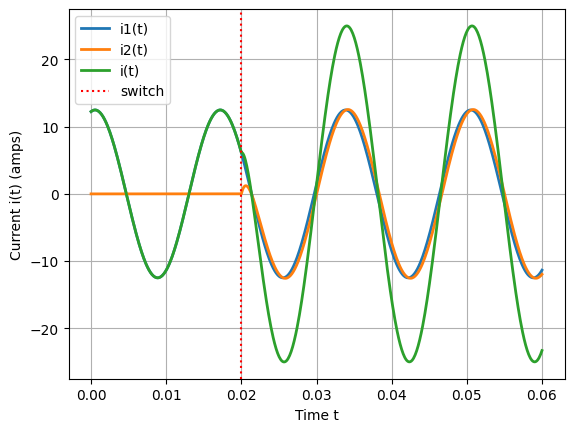

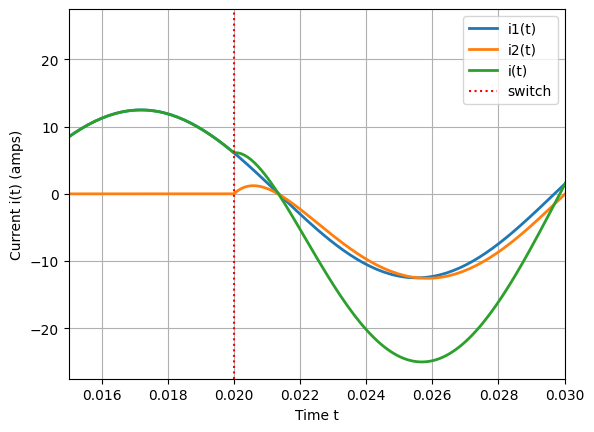

In [272]:
## Making of Fig. 14, 15
# add initial conditions for plotting
t_init = 0.02      # length of time for initial 
step = 0.0001      # step size
t_init_rng = np.arange(0,t_init,step)               # make steps
i1_init = Is_t(t_init_rng,Is,f)                     # make init i1 signal
i2_init = i2_0 * np.ones(t_init_rng.shape)          # i2
i_init = Is_t(t_init_rng,Is,f)                      # i
t = np.concatenate((t_init_rng, sol.t))      # make total time vector
i1_t = np.concatenate((i1_init, sol.y[0]))          # concat
i2_t = np.concatenate((i2_init, sol.y[1]))          # concat
i_t = np.concatenate((i_init, sol.y[0]+sol.y[1]))   # concat

# plot the response
plt.plot(t, i1_t, label='i1(t)',linewidth=2)
plt.plot(t, i2_t, label='i2(t)',linewidth=2)
plt.plot(t, i_t, label='i(t)',linewidth=2)
plt.axvline(x=t_init,label='switch',color='r',linestyle=':')
plt.xlabel('Time t')
plt.ylabel('Current i(t) (amps)')
plt.grid(True)
plt.legend()
plt.show()
# plot the response - zoom in on the switch
plt.plot(t, i1_t, label='i1(t)',linewidth=2)
plt.plot(t, i2_t, label='i2(t)',linewidth=2)
plt.plot(t, i_t, label='i(t)',linewidth=2)
plt.axvline(x=t_init,label='switch',color='r',linestyle=':')
plt.xlabel('Time t')
plt.ylabel('Current i(t) (amps)')
plt.grid(True)
plt.xlim([0.015,0.03])
plt.legend()
plt.show()


## THERE IS A BUG IN THIS EXAMPLE SOMEWHERE... IGNORE

## Section III.C: DC Example with Line and Load

Studying a circuit with a line connected to a load, then a switch closes adding more load, and observing the transient response. 

Circuit in question (Fig. 14):

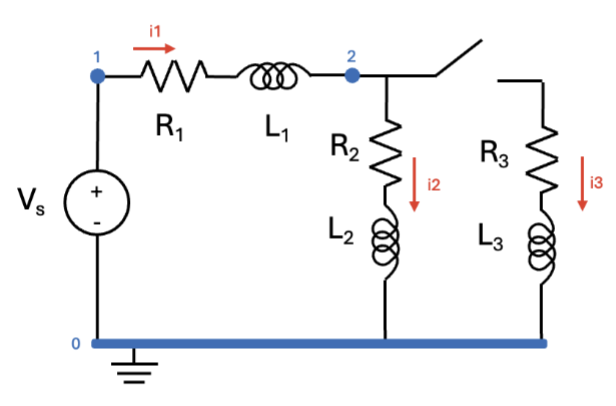

In [273]:
## Constants: 
Rall = np.array([4, 3, 5])             # ohms
Lall = np.array([0.25, 0.5, 1/3])      # henrys
Vs = 24                             # volts

## find intial conditions
i1_0 = Vs / (Rall[0] + Rall[1])         # Ohm's law - initial current flowing through connected branch
i2_0 = i1_0              # initially no current in the other branch so... 
i3_0 = 0                # "    "

## Function of the differential equations
def dxdt(t, x):
    c_dx2 = (Lall[0]+Lall[1]+Lall[0]*Lall[1]/Lall[2])
    c_dx3 = (Lall[0]+Lall[2]+Lall[0]*Lall[2]/Lall[1])
    Am = np.array([
        [-(Rall[0] + Rall[1] + Lall[0]*Rall[1]/Lall[2])/c_dx2,  -(Rall[0] - Lall[0]*Rall[2]/Lall[2])/c_dx3        ],
        [-(Rall[0] - Lall[0]*Rall[1]/Lall[1])/c_dx3,            -(Rall[0] + Rall[2] + Lall[0]*Rall[2]/Lall[1])/c_dx3 ]
    ])
    b = np.array([
        Vs / c_dx2,
        Vs / c_dx3
    ])
    return Am @ x + b

## simulate the response
tspan = (0,2)
x0 = [i2_0, i3_0]
sol = spi.solve_ivp(dxdt, tspan, x0, max_step=0.001)

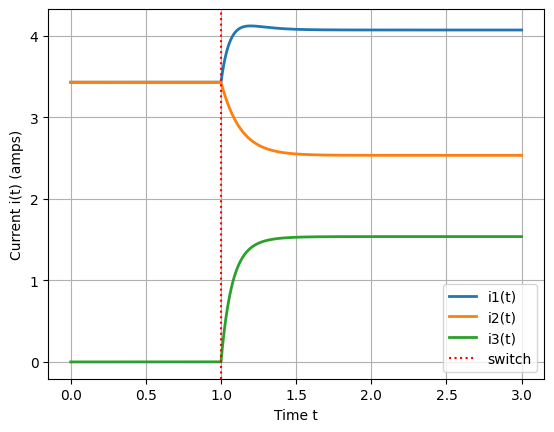

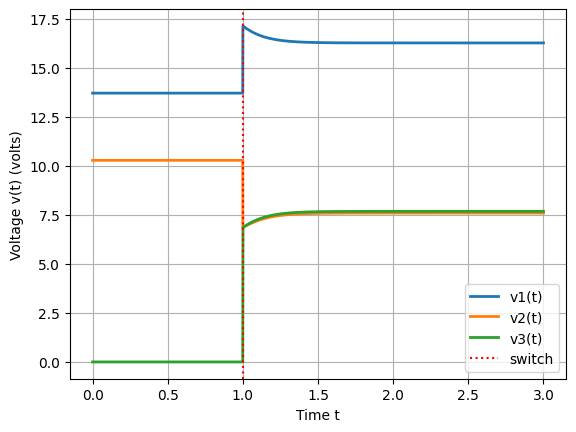

In [274]:
## Making of Fig. 15 & 16
# add initial conditions for plotting
t_init = 1      # length of time for initial 
step = 0.001      # step size
t_init_rng = np.arange(0,t_init,step)               # make steps
i2_init = i2_0 * np.ones(t_init_rng.shape)          # make init i1 signal
i3_init = i3_0 * np.ones(t_init_rng.shape)          # i2
i1_init = i1_0 * np.ones(t_init_rng.shape)            # i
t = np.concatenate((t_init_rng, sol.t+t_init))      # make total time vector
i2_t = np.concatenate((i2_init, sol.y[0]))          # concat
i3_t = np.concatenate((i3_init, sol.y[1]))          # concat
i1_t = np.concatenate((i1_init, sol.y[0]+sol.y[1]))   # concat

## compute voltage based on current
di2dt = np.gradient(i2_t,t)
di3dt = np.gradient(i3_t,t)
di1dt = di2dt + di3dt
v2_t = Rall[1]*i2_t + Lall[1]*di2dt
v3_t = Rall[2]*i3_t + Lall[2]*di3dt
v1_t = Rall[0]*i1_t + Lall[0]*di1dt

## plot the responses
# current
plt.plot(t, i1_t, label='i1(t)',linewidth=2)
plt.plot(t, i2_t, label='i2(t)',linewidth=2)
plt.plot(t, i3_t, label='i3(t)',linewidth=2)
plt.axvline(x=t_init,label='switch',color='r',linestyle=':')
plt.xlabel('Time t')
plt.ylabel('Current i(t) (amps)')
plt.grid(True)
plt.legend()
plt.show()
# voltage
plt.plot(t, v1_t, label='v1(t)',linewidth=2)
plt.plot(t, v2_t, label='v2(t)',linewidth=2)
plt.plot(t, v3_t, label='v3(t)',linewidth=2)
plt.axvline(x=t_init,label='switch',color='r',linestyle=':')
plt.xlabel('Time t')
plt.ylabel('Voltage v(t) (volts)')
plt.grid(True)
plt.legend()
plt.show()

## Section IV.D: Full Network in DC

Analyzing the full network with with a DC source (line parameters are different because DC)

Circuit in question (Fig. 17):

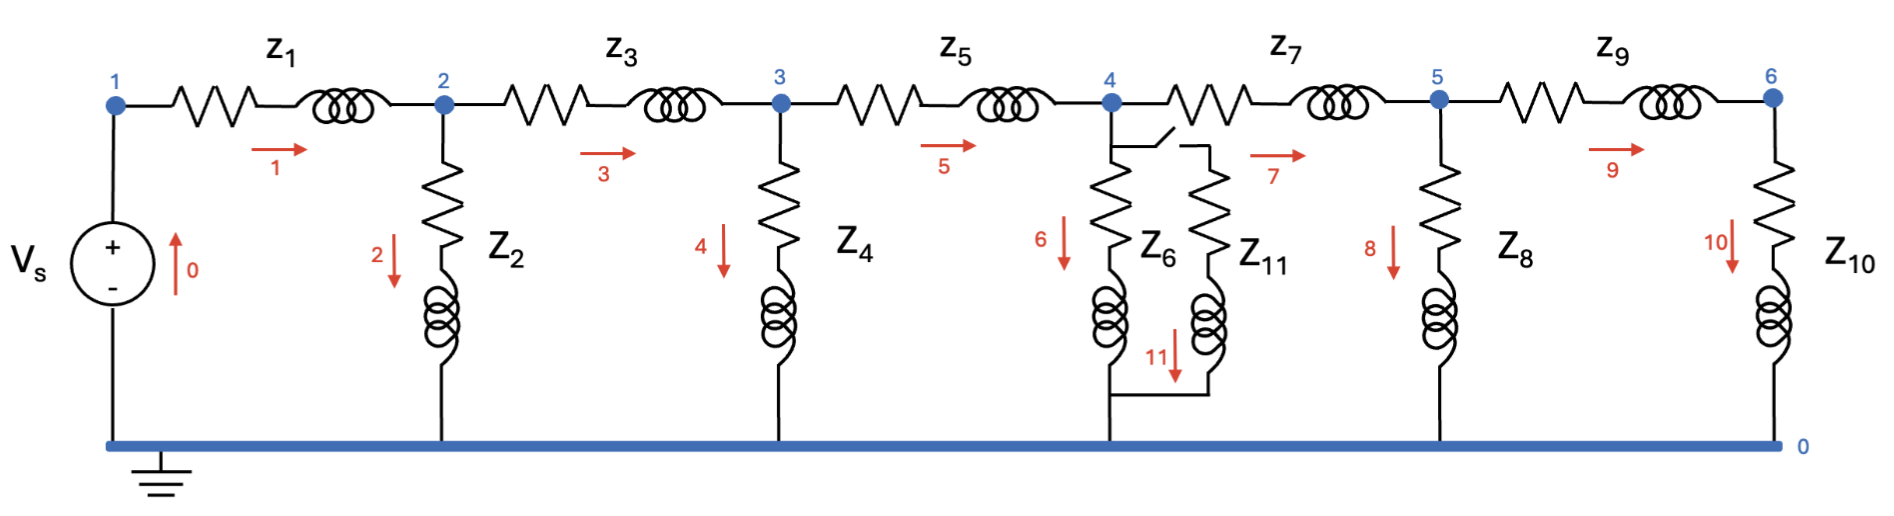

In [275]:
## Functions
# define the coefficient matrix using a vector of values (input is 0 indexed but then adjusted to 1-index for putting into matrix)
def form_mat(xin):
    x = np.insert(xin,0,0)  # put a zero so the index lines up with my math
    Xm = np.array([  [x[1]+x[2], x[1],       x[1],       x[1],       x[1],       x[1]], 
                    [-x[2],     x[3]+x[4],  x[3],       x[3],       x[3],       x[3]], 
                    [0,         -x[4],      x[5]+x[6],  x[5],       x[5],       x[5]], 
                    [0,         0,          -x[6],      0,          0,          x[11]], 
                    [0,         0,          0,          x[7]+x[8],  x[7],       -x[11]], 
                    [0,         0,          0,          -x[8],      x[9]+x[10], 0]])
    return Xm

In [276]:
## Constants
Rload = np.random.uniform(2, 5, size=6)
Lload = Rload/10
Rline = np.random.uniform(0.2, 0.5, size=5)
Rall = np.column_stack((Rline, Rload[0:5])).ravel()
Rall = np.append(Rall,Rload[-1])
Lall = Rall/10
Vs = 24

## find initial states by solving steady state DC with inductors as shorts
y = 1 / Rall                       # Admittance
Ym = np.array([[y[0]+y[1]+y[2], -y[2],           0,              0,              0],
              [-y[2],           y[2]+y[3]+y[4], -y[4],          0,              0],
              [0,               -y[4],          y[4]+y[5]+y[6], -y[6],          0],
              [0,               0,              -y[6],          y[6]+y[7]+y[8], -y[8]],
              [0,               0,              0,              -y[8],          y[8]+y[9]]])  # Admittance matrix
i = np.array([Vs * y[0], 0, 0, 0, 0])  # Current vector
Vall = np.linalg.inv(Ym) @ i    # Solve for voltages
iall_0 = Vall / Rload[0:5]     # compute current initial conditions


## set up differential equation
# deal with the new node and form R/L matrices
iall_0 = np.append(iall_0,0)            # add a zero for i11
Lm = form_mat(Lall)
Lm_i = np.linalg.inv(Lm) 
Rm = form_mat(Rall)
v = np.array([Vs, 0, 0, 0, 0, 0])
# differential equation functon block
def dxdt(t, x):
    dx = Lm_i @ v -  Lm_i @ Rm @ x
    return dx

## simulate the response
tspan = (0,0.5)
sol = spi.solve_ivp(dxdt, tspan, iall_0, max_step=0.001)

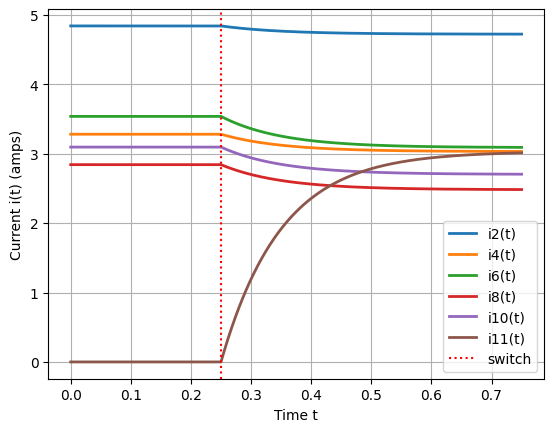

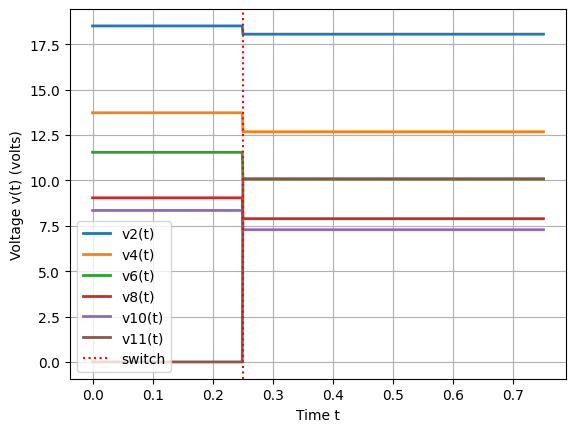

In [277]:
## Making of Fig. 17 & Fig. 18
# add initial conditions for plotting
t_init = 0.25      # length of time for initial 
step = 0.001      # step size
t_init_rng = np.arange(0,t_init,step)               # make steps
i_init = np.ones((6,t_init_rng.shape[0])) * iall_0[:, np.newaxis]
t = np.concatenate((t_init_rng, sol.t+t_init))      # make total time vector
iall = np.concatenate((i_init,sol.y),axis=1)
i1 = np.sum(iall, axis=0)

## compute voltages
didtall = get_deriv(iall,t)               # take derivative of current signals
vall = Rload[:, np.newaxis] * iall + Lload[:, np.newaxis] * didtall     # compute voltage through inductors

## plot the responses
# current response
idx_i = [2, 4, 6, 8, 10, 11]
for i in range(6):
    plt.plot(t, iall[i,:], label=f'i{idx_i[i]}(t)', linewidth=2)
plt.axvline(x=t_init,label='switch',color='r',linestyle=':')
plt.xlabel('Time t')
plt.ylabel('Current i(t) (amps)')
plt.grid(True)
plt.legend()
plt.show()
# voltage response
for i in range(6):
    plt.plot(t, vall[i,:], label=f'v{idx_i[i]}(t)', linewidth=2)
plt.axvline(x=t_init,label='switch',color='r',linestyle=':')
plt.xlabel('Time t')
plt.ylabel('Voltage v(t) (volts)')
plt.grid(True)
plt.legend()
plt.show()

## Section III.E: Full Network in DC with Capacitor

Analyzing the full network with original line and load parameters

Circuit in question (fig. 20):

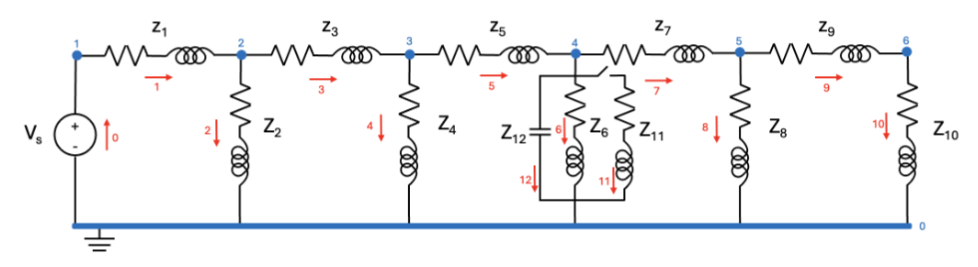

In [278]:
## functions
# form the coefficient matrices
def form_mat2(xin,LorR,C):
    # C - capacitance, if needed
    # L or R: for R, = 1, for L, = 0
    x = np.insert(xin,0,0)  # put a zero at the beginning so the index lines up with my math
    if LorR == 1:           # R matrix
        Xm = np.array([  [x[1]+x[2], x[1],       x[1],       x[1],       x[1],       x[1],       x[1],   0], 
                        [-x[2],     x[3]+x[4],  x[3],       x[3],       x[3],       x[3],       x[3],   0], 
                        [0,         -x[4],      x[5],       x[5],       x[5],       x[5],       x[5],   1], 
                        [0,         0,          x[6],       0,          0,          0,          0,      -1], 
                        [0,         0,          0,          0,          0,          x[11],      0,      -1],
                        [0,         0,          0,          0,          0,          0,          1/C,    0],
                        [0,         0,          0,          x[7]+x[8],  x[7],       0,          0,      -1], 
                        [0,         0,          0,          -x[8],      x[9]+x[10], 0,          0,      0]])
    else:                   # L matrix
        Xm = np.array([  [x[1]+x[2], x[1],       x[1],       x[1],       x[1],       x[1],       x[1],   0], 
                        [-x[2],     x[3]+x[4],  x[3],       x[3],       x[3],       x[3],       x[3],   0], 
                        [0,         -x[4],      x[5],       x[5],       x[5],       x[5],       x[5],   0], 
                        [0,         0,          x[6],       0,          0,          0,          0,      0], 
                        [0,         0,          0,          0,          0,          x[11],      0,      0],
                        [0,         0,          0,          0,          0,          0,          0,      -1],
                        [0,         0,          0,          x[7]+x[8],  x[7],       0,          0,      0], 
                        [0,         0,          0,          -x[8],      x[9]+x[10], 0,          0,      0]])  
    return Xm

In [279]:
## Constants
# use same constants as previous example
Cap = 1/3

## find initial states by solving steady state DC with inductors as shorts
# initial conditions are the same as previous example: use iall_0
iall_0 = np.append(iall_0,0)            # add another zero for i12
v4_0 = Vall[2]                          # initial voltage at node 4 from previous

## form R/L matrices
init_condish = np.append(iall_0,v4_0)   # put v4 initial condition on the end
Lm = form_mat2(Lall,0,0)
Lm_i = np.linalg.inv(Lm) 
Rm = form_mat2(Rall,1,Cap)
v = np.array([Vs, 0, 0, 0, 0, 0, 0, 0])

## set up differential equation
def dxdt(t, x):
    dx = Lm_i @ v -  Lm_i @ Rm @ x
    return dx

## simulate the response
tspan = (0,1.5)
sol = spi.solve_ivp(dxdt, tspan, init_condish, max_step=0.001)

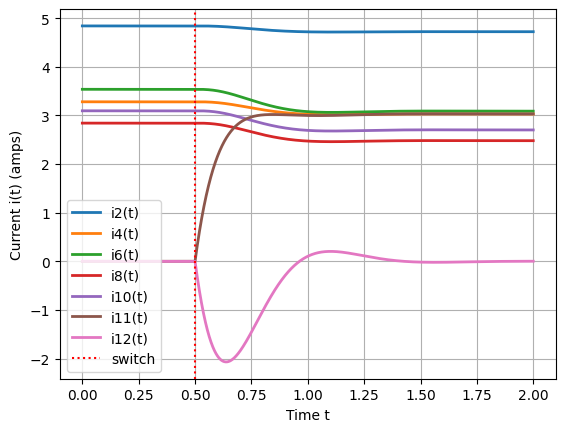

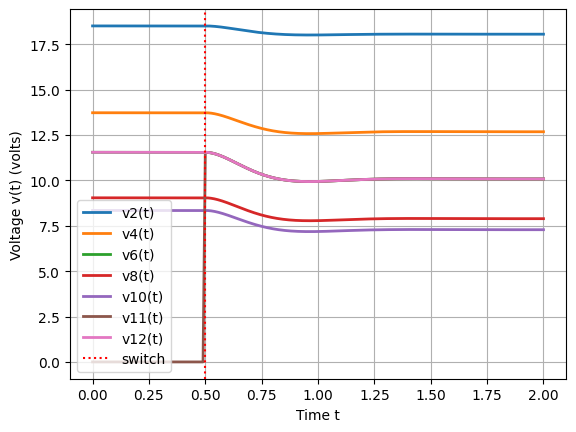

In [280]:
## Making of Fig. 20 & Fig. 21
# add initial conditions for plotting
t_init = 0.5      # length of time for initial 
step = 0.01      # step size
t_init_rng = np.arange(0,t_init,step)               # make steps
i_init = np.ones((7,t_init_rng.shape[0])) * iall_0[:, np.newaxis]
v_init = np.ones((t_init_rng.shape[0])) * v4_0
t = np.concatenate((t_init_rng, sol.t+t_init))      # make total time vector
iall = np.concatenate((i_init,sol.y[0:7,:]),axis=1)
v12 = np.concatenate((v_init,sol.y[-1,:]))           # renaming to 6 because it goes through the capacitor (12)
i1 = np.sum(iall, axis=0)

## compute voltages
didtall = get_deriv(iall,t)               # take derivative of current signals
vall = Rload[:, np.newaxis] * iall[0:6,:] + Lload[:, np.newaxis] * didtall[0:6,:]     # compute voltage through inductors

## plot the response
# current
idx_i = [2, 4, 6, 8, 10, 11, 12]
for i in range(7):
    plt.plot(t, iall[i,:], label=f'i{idx_i[i]}(t)', linewidth=2)
# plt.plot(t, vall, label='v6(t)', linewidth=2)
plt.axvline(x=t_init,label='switch',color='r',linestyle=':')
plt.xlabel('Time t')
plt.ylabel('Current i(t) (amps)')
plt.grid(True)
plt.legend()
plt.show()
# plot the response
for i in range(6):
    plt.plot(t, vall[i,:], label=f'v{idx_i[i]}(t)', linewidth=2)
plt.plot(t, v12, label='v12(t)', linewidth=2)
plt.axvline(x=t_init,label='switch',color='r',linestyle=':')
plt.xlabel('Time t')
plt.ylabel('Voltage v(t) (volts)')
plt.grid(True)
plt.legend()
plt.show()

## Section IV.F: Full Network in AC Without Capacitor

Study of the network from Sec. IV.D (fig. 17) but with an AC source, not DC - use original line parameters from steady state problem



In [281]:
## constants
# use original z values
z = np.column_stack((zline, zload[0:5])).ravel()  # Combine line and load impedances
Vs = 240 + 0j  # Source voltage
f = 60
ts = 0.02       # explicit time for switch to close

# print(np.round(zline,3))
# print(np.round(zload,3))

## Determine initial states
y = 1 / z  # Admittance
Ym = np.array([[y[0]+y[1]+y[2], -y[2],          0,              0,              0],
              [-y[2],           y[2]+y[3]+y[4], -y[4],          0,              0],
              [0,               -y[4],          y[4]+y[5]+y[6], -y[6],          0],
              [0,               0,              -y[6],          y[6]+y[7]+y[8], -y[8]],
              [0,               0,              0,              -y[8],          y[8]+y[9]]])  # Admittance matrix
i = np.array([Vs * y[0], 0, 0, 0, 0])  # Current vector
Vall = np.linalg.inv(Ym) @ i  # Solve for voltages (phasor) [nodes: 2,3,4,5,6]
i0rms = Vall / zload[0:5]         # compute current initial conditions (phasor)
# convert from phasor to v(t),i(t) - voltage and current as fns of time
def V_t(t,Vrms,f):
    return np.abs(Vrms)*np.sqrt(2) * np.cos(2*np.pi*f*t + np.angle(Vrms))
def I_t(t,Irms,f):
    return np.abs(Irms)*np.sqrt(2) * np.cos(2*np.pi*f*t + np.angle(Irms))
i0 = I_t(ts,i0rms,f)          # initial currents (i2,4,6,8,10) at time t=0.03
v0 = V_t(ts,Vs,f)             # initial source voltage at time of switch

## form R/L matrices
z = np.append(z,zload[2])               # add z11 (equal to z6) to the end of the vector
Lall = np.imag(z) / (2*np.pi*f)         # compute L's from z values
Lload = np.imag(zload) / (2*np.pi*f)    # compute L's from z values
Rall = np.real(z)                       # compute R's 
Rload = np.real(zload)                  # compute R's from zload values
i0 = np.append(i0,0)                    # add a zero for i11
i0rms = np.append(i0rms,0+0j)           # add a zero for i11
Lm = form_mat(Lall)
Lm_i = np.linalg.inv(Lm) 
Rm = form_mat(Rall)

## set up differential equation
def dxdt(t, x):
    Vs_t = V_t(t,Vs,f)          # explicit in time
    v = np.array([Vs_t, 0, 0, 0, 0, 0])
    dx = Lm_i @ v -  Lm_i @ Rm @ x
    return dx

## simulate the response
tspan = (ts,2*ts)
sol = spi.solve_ivp(dxdt, tspan, i0, max_step=0.0001)


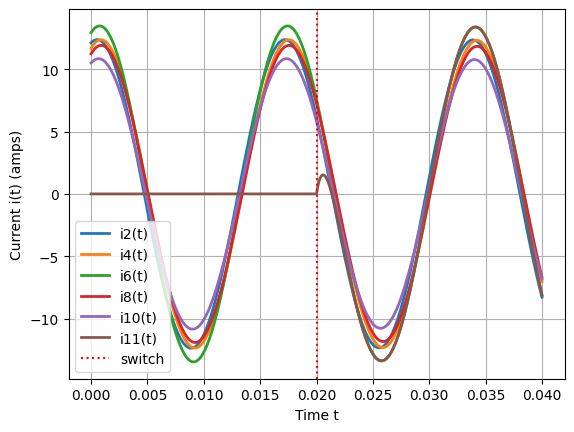

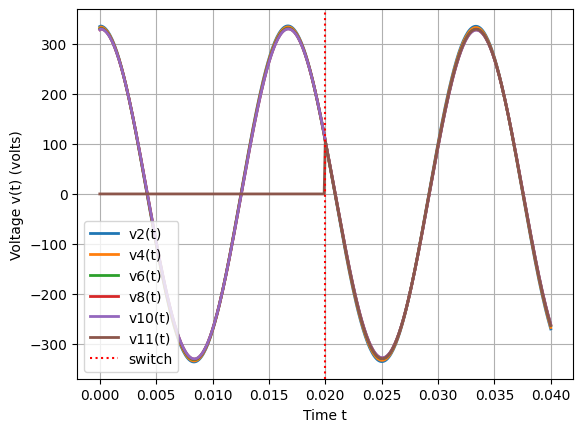

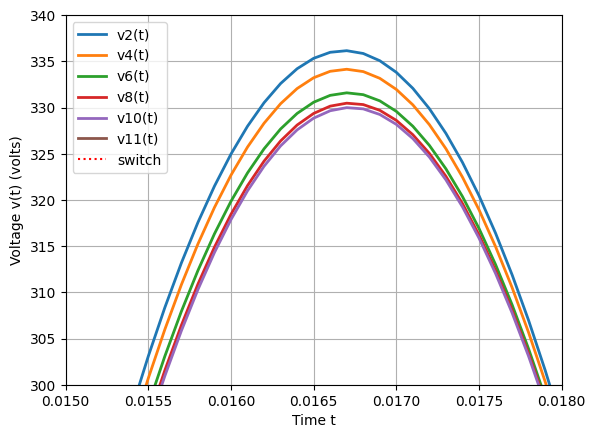

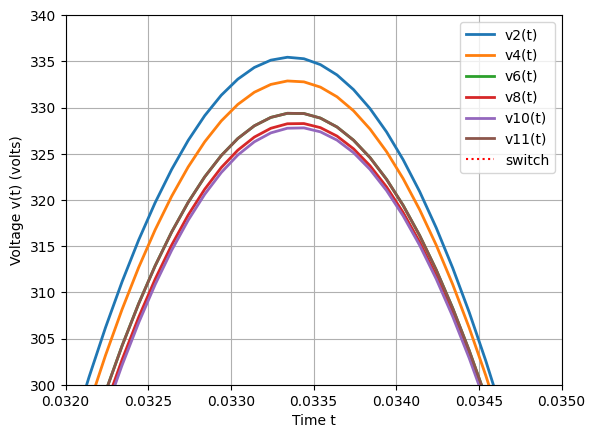

In [282]:
## Making of Fig. 22 - 25
# add initial conditions for plotting
t_init = ts      # length of time for initial 
step = 0.0001      # step size
t_init_rng = np.arange(0,t_init,step)               # make steps
i_init = np.zeros((6,t_init_rng.shape[0]))
for i,t in enumerate(t_init_rng):
    i_init[:,i] = I_t(t,i0rms,f)
t = np.concatenate((t_init_rng, sol.t))      # make total time vector
iall = np.concatenate((i_init,sol.y),axis=1)
i1 = np.sum(iall, axis=0)

## compute voltages
# extract load impedances first
Lload = np.append(Lload,Lload[2])       # add L11 (equal to L6) to the end of the vector
Rload = np.append(Rload,Rload[2])       # add R11
# compute voltages
didtall = get_deriv(iall,t)               # take derivative of current signals
vall = Rload[:, np.newaxis] * iall[0:6,:] + Lload[:, np.newaxis] * didtall[0:6,:]     # compute voltage through inductors
# store for a later plot
vall_nocap = vall.copy()                # store the voltages before adding a capacitor

## plot the response
# current
idx_i = [2, 4, 6, 8, 10, 11]
for i in range(6):
    plt.plot(t, iall[i,:], label=f'i{idx_i[i]}(t)', linewidth=2)
plt.axvline(x=t_init,label='switch',color='r',linestyle=':')
plt.xlabel('Time t')
plt.ylabel('Current i(t) (amps)')
plt.grid(True)
plt.legend()
plt.show()
# voltage
for i in range(6):
    plt.plot(t, vall[i,:], label=f'v{idx_i[i]}(t)', linewidth=2)
plt.axvline(x=t_init,label='switch',color='r',linestyle=':')
plt.xlabel('Time t')
plt.ylabel('Voltage v(t) (volts)')
plt.grid(True)
plt.legend()
plt.show()
# voltage zoomed in BEFORE SWITCH
for i in range(6):
    plt.plot(t, vall[i,:], label=f'v{idx_i[i]}(t)', linewidth=2)
plt.axvline(x=t_init,label='switch',color='r',linestyle=':')
plt.xlabel('Time t')
plt.xlim([0.015, 0.018])
plt.ylim([300,340])
plt.ylabel('Voltage v(t) (volts)')
plt.grid(True)
plt.legend()
plt.show()
# voltage zoomed in AFTER SWITCH
for i in range(6):
    plt.plot(t, vall[i,:], label=f'v{idx_i[i]}(t)', linewidth=2)
plt.axvline(x=t_init,label='switch',color='r',linestyle=':')
plt.xlabel('Time t')
plt.xlim([0.032, 0.035])
plt.ylim([300,340])
plt.ylabel('Voltage v(t) (volts)')
plt.grid(True)
plt.legend()
plt.show()

## Section IV.G: Full Network in AC with Capacitor

A repeat of the previous study but with a capacitor bank installed at node 4

In [283]:
## Constants
# use original z values
z = np.column_stack((zline, zload[0:5])).ravel()  # Combine line and load impedances
Vs = 240 + 0j  # Source voltage
f = 60
ts = 0.02           # explicit time for switch to close
Cap = 2.877e-05     # from previous calculation
Zc = -1j*92.208      # capacitive reactance at 60Hz = -1/(2*np.pi*f*Cap)

## Determine initial states
y = 1 / z  # Admittance
Ym = np.array([[y[0]+y[1]+y[2], -y[2],          0,                      0,              0],
              [-y[2],           y[2]+y[3]+y[4], -y[4],                  0,              0],
              [0,               -y[4],          y[4]+y[5]+y[6]+1/Zc,    -y[6],          0],             #THIS LINE ADDDED CAPACITANCE - should just cancel the reactive component of y[6]
              [0,               0,              -y[6],                  y[6]+y[7]+y[8], -y[8]],
              [0,               0,              0,                      -y[8],          y[8]+y[9]]])  # Admittance matrix
i = np.array([Vs * y[0], 0, 0, 0, 0])  # Current vector
Vall = np.linalg.inv(Ym) @ i        # Solve for voltages - [V2, V3, V4, V5, V6] <- nodes (or [V2, V4, V6, V8, V10] <- loads)
i0rms = Vall / zload[0:5]           # compute current initial conditions for all loads (phasor)
i0rms = np.append(i0rms,0+0j)       # add a zero for i11 (capacitor current phasor)
ic0 = Vall[2] / Zc                  # compute initial current through capacitor (phasor)
i0rms = np.append(i0rms,ic0)        # append capacitor current to the end of the vector
# convert from phasor to v(t),i(t) - voltage and current as fns of time
def V_t(t,Vrms,f):
    return np.abs(Vrms)*np.sqrt(2) * np.cos(2*np.pi*f*t + np.angle(Vrms))
def I_t(t,Irms,f):
    return np.abs(Irms)*np.sqrt(2) * np.cos(2*np.pi*f*t + np.angle(Irms))
iall_0 = I_t(ts,i0rms,f)            # initial currents (i2,4,6,8,10,11,12) at time t=0.03
v0 = V_t(ts,Vs,f)               # initial source voltage at time t=0.03
v4_0 = V_t(ts,Vall[2],f)        # initial voltage at node 4 through capacitor

## form R/L matrices
# deal with the extra load 
Lall = np.imag(z) / 2/ np.pi / f        # compute L's from z values
Lall = np.append(Lall,Lload[2])         # add L11 (equal to L6) to the end of the vector
Lload = np.imag(zload) / 2/ np.pi / f   # compute L's from z values
Lload = np.append(Lload,Lload[2])       # add L11 (equal to L6) to the end of the vector
Rall = np.real(z)                       # compute R's
Rall = np.append(Rall,Rload[2])         # add R11 (equal to R6) to the end of the vector
Rload = np.real(zload)                  # compute R's
Rload = np.append(Rload,Rload[2])       # add R11 (equal to R6) to the end of the vector
# states and matrices
init_condish = np.append(iall_0,v4_0)   # put v4 initial condition on the end: state vec: i2,4,6,8,10,11,12,v4
Lm = form_mat2(Lall,0,0)
Lm_i = np.linalg.inv(Lm) 
Rm = form_mat2(Rall,1,Cap)

## set up differential equation
def dxdt(t, x):
    Vs_t = V_t(t,Vs,f)          # explicit in time
    v = np.array([Vs_t, 0, 0, 0, 0, 0, 0, 0])
    dx = Lm_i @ v -  Lm_i @ Rm @ x
    return dx

## simulate the response
tspan = (ts,ts*2)
sol = spi.solve_ivp(dxdt, tspan, init_condish, max_step=0.0001)

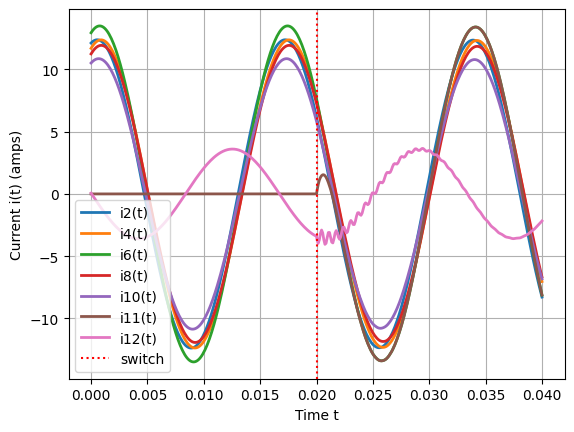

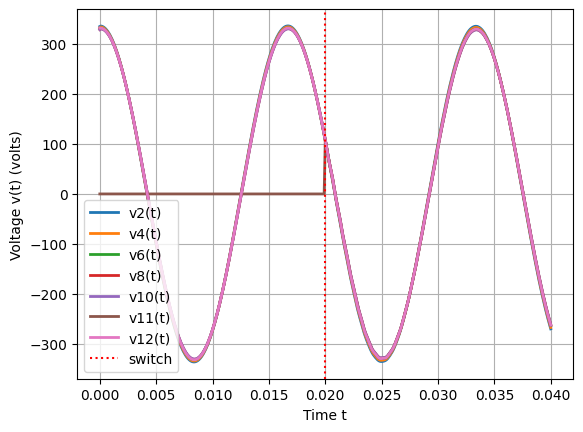

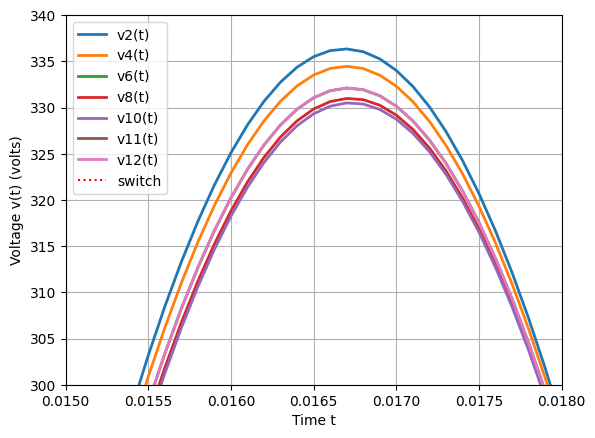

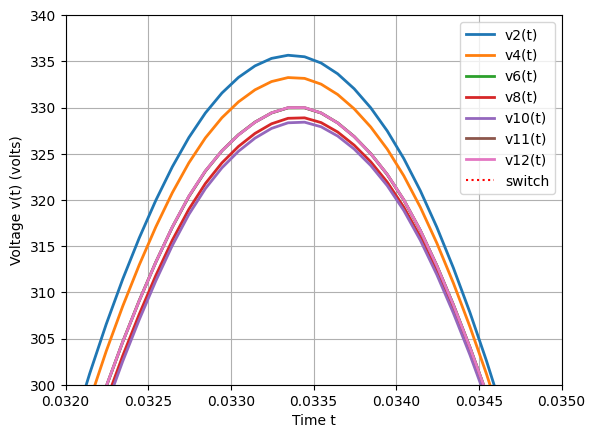

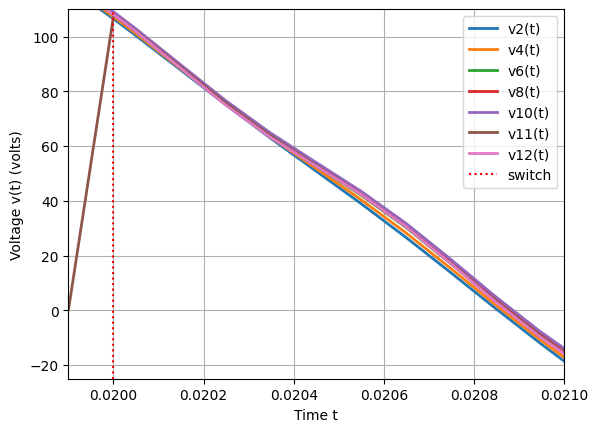

In [284]:
## Making of Fig. 26
# add initial conditions for plotting
t_init = ts      # length of time for initial 
step = 0.0001      # step size
t_init_rng = np.arange(0,t_init,step)               # make steps
i_init = np.zeros((7,t_init_rng.shape[0]))
for i,t in enumerate(t_init_rng):       # step forward in time to create initial wave forms
    i_init[:,i] = I_t(t,i0rms,f)
v12_init = V_t(t_init_rng,Vall[2],f)          # initial voltage at node 4 through capacitor
t = np.concatenate((t_init_rng, sol.t))      # make total time vector
iall = np.concatenate((i_init,sol.y[0:7,:]),axis=1)
v12 = np.concatenate((v12_init,sol.y[-1,:]))     

## compute voltages
didtall = get_deriv(iall,t)               # take derivative of current signals
vall = Rload[:, np.newaxis] * iall[0:6,:] + Lload[:, np.newaxis] * didtall[0:6,:]     # compute voltage through inductors
vall_cap = vall.copy()                # store the voltages

## plot the response
# current
idx_i = [2, 4, 6, 8, 10, 11, 12]
for i in range(7):
    plt.plot(t, iall[i,:], label=f'i{idx_i[i]}(t)', linewidth=2)
plt.axvline(x=t_init,label='switch',color='r',linestyle=':')
plt.xlabel('Time t')
plt.ylabel('Current i(t) (amps)')
plt.grid(True)
plt.legend()
plt.show()
# voltage
for i in range(6):
    plt.plot(t, vall[i,:], label=f'v{idx_i[i]}(t)', linewidth=2)
plt.plot(t, v12, label='v12(t)', linewidth=2)
plt.axvline(x=t_init,label='switch',color='r',linestyle=':')
plt.xlabel('Time t')
plt.ylabel('Voltage v(t) (volts)')
plt.grid(True)
plt.legend()
plt.show()
# voltage - before switch
for i in range(6):
    plt.plot(t, vall[i,:], label=f'v{idx_i[i]}(t)', linewidth=2)
plt.plot(t, v12, label='v12(t)', linewidth=2)
plt.axvline(x=t_init,label='switch',color='r',linestyle=':')
plt.xlabel('Time t')
plt.ylabel('Voltage v(t) (volts)')
plt.xlim([0.015, 0.018])
plt.ylim([300,340])
plt.grid(True)
plt.legend()
plt.show()
# voltage - after switch
for i in range(6):
    plt.plot(t, vall[i,:], label=f'v{idx_i[i]}(t)', linewidth=2)
plt.plot(t, v12, label='v12(t)', linewidth=2)
plt.axvline(x=t_init,label='switch',color='r',linestyle=':')
plt.xlabel('Time t')
plt.ylabel('Voltage v(t) (volts)')
plt.xlim([0.032, 0.035])
plt.ylim([300,340])
plt.grid(True)
plt.legend()
plt.show()

# voltage - after switch
for i in range(6):
    plt.plot(t, vall[i,:], label=f'v{idx_i[i]}(t)', linewidth=2)
plt.plot(t, v12, label='v12(t)', linewidth=2)
plt.axvline(x=t_init,label='switch',color='r',linestyle=':')
plt.xlabel('Time t')
plt.ylabel('Voltage v(t) (volts)')
plt.xlim([0.0199, 0.021])
plt.ylim([-25,110])
plt.grid(True)
plt.legend()
plt.show()




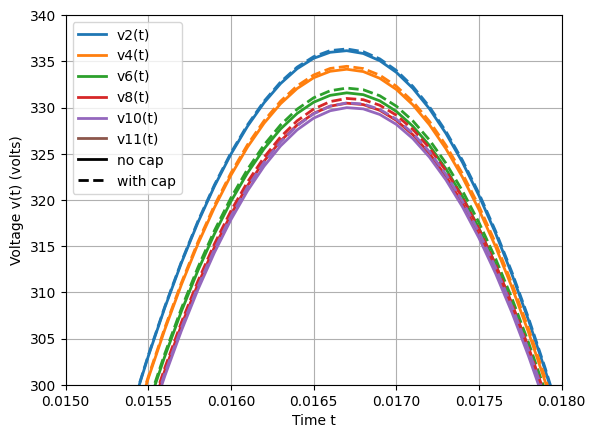

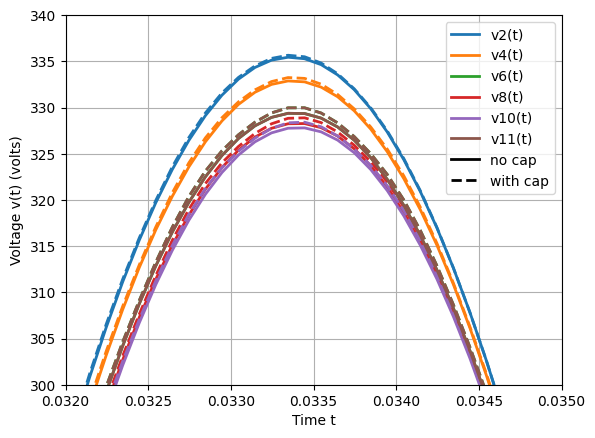

In [285]:
## Make figures to compare before and after the switch - Fig. 27, 28
# voltage - before switch
for i in range(6):
    line, = plt.plot(t, vall_nocap[i,:], label=f'v{idx_i[i]}(t)', linewidth=2)
    plt.plot(t,vall_cap[i,:], linestyle='--', color=line.get_color(), linewidth=2)
plt.xlabel('Time t')
plt.ylabel('Voltage v(t) (volts)')
plt.xlim([0.015, 0.018])
plt.ylim([300,340])
plt.grid(True)
plt.plot(1,1, linestyle='-', color='k', linewidth=2, label='no cap')
plt.plot(1,1, linestyle='--', color='k', linewidth=2, label='with cap')
plt.legend()
plt.show()

# voltage - after switch
for i in range(6):
    line, = plt.plot(t, vall_nocap[i,:], label=f'v{idx_i[i]}(t)', linewidth=2)
    plt.plot(t,vall_cap[i,:], linestyle='--', color=line.get_color(), linewidth=2)
plt.xlabel('Time t')
plt.ylabel('Voltage v(t) (volts)')
plt.xlim([0.032, 0.035])
plt.ylim([300,340])
plt.grid(True)
plt.plot(1,1, linestyle='-', color='k', linewidth=2, label='no cap')
plt.plot(1,1, linestyle='--', color='k', linewidth=2, label='with cap')
plt.legend()
plt.show()

In [286]:
# # print(np.angle(Vall))
# # print(np.angle(i0rms))
# # print(np.angle(zload))

# print(zload)

# # plot initial voltages:
# step = 0.00001      # step size
# t_init_rng = np.arange(0,t_init,step)
# vall_t = np.zeros((5, t_init_rng.shape[0]))  # initialize voltage array
# for i,t in enumerate(t_init_rng):
#     vall_t[:,i] = V_t(t,Vall,f)

# idx_i = [2, 3, 4, 5, 6]
# for i in range(5):
#     plt.plot(t_init_rng, vall_t[i,:], label=f'v{idx_i[i]}(t)', linewidth=2)
# plt.axvline(x=t_init,label='switch',color='r',linestyle=':')
# plt.xlabel('Time t')
# plt.ylabel('NODE Voltage v(t) (volts)')
# plt.grid(True)
# plt.xlim([0,0.002])
# plt.ylim([300,355])
# plt.legend()
# plt.show()

# # try again using currents
# iall_t = np.zeros((5, t_init_rng.shape[0]))  # initialize current array
# for i,t in enumerate(t_init_rng):
#     iall_t[:,i] = I_t(t,i0rms[0:5],f)

# print(iall_t.shape)

# didt = get_deriv(iall_t,t_init_rng)  # take derivative of current signals
# vall_t_fromi = Rload[:, np.newaxis] * iall_t + Lload[:, np.newaxis] * didt  # compute voltage through inductors
# for i in range(5):
#     plt.plot(t_init_rng, vall_t_fromi[i,:], label=f'v{idx_i[i]}(t)', linewidth=2)
# plt.axvline(x=t_init,label='switch',color='r',linestyle=':')
# plt.xlabel('Time t')
# plt.ylabel('NODE Voltage v(t) (volts)')
# plt.grid(True)
# plt.xlim([0,0.002])
# plt.ylim([300,355])
# plt.legend()
# plt.show()

# plt.plot(t_init_rng, iall_t[0,:], label='i2(t)', linewidth=2)
# plt.plot(t_init_rng,didt[0,:], label='di2/dt', linewidth=2)
# plt.show()
